## Exercise 3- Neural Networks & Multi-class Classification

In [1]:
# import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from PIL import Image
import matplotlib.cm as cm 
import random
from scipy.special import expit

### Multi-class Classification

In [2]:
input_file = 'database/ex3data1.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)
X, y = mat_data['X'], mat_data['y']

# insert ones to X (x0)
X = np.insert(X,0,1,axis=1)

# displaying shapes of X & y
print(X.shape ,mat_data['y'].shape)

# X contains 5000 images, therefore 5000 rows. Each image has 400 pixels unrolled (20x20).
# y is a classification for each image. 1-10, where "10" is the handwritten "0"

(5000, 401) (5000, 1)


In [3]:
# creating a function to display matrix as an image
# reference- https://github.com/scipy/scipy/blob/368dbad596a0bd0d5a88a7aec381fdc912440ee1/scipy/misc/pilutil.py#L286-L409
import numpy as np
from PIL import Image


_errstr = "Mode is unknown or incompatible with input array shape."


def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

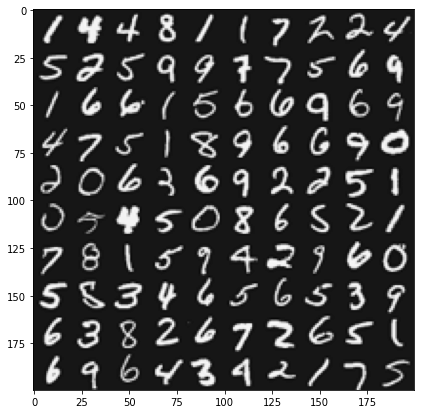

In [4]:
def getImage(x):
    """
    Input: np array with shape 1*400
    Output: image object 
    """
    w, h = 20, 20
    sq = x[1:].reshape(w,h)
    return sq.T
    
def displayData(display_indices = None):
    """
    Picks 100 random rows from X, creates a grid of images, and displays the same.
    """
    w, h = 20, 20
    num_rows, num_columns = 10, 10
    if not display_indices:
        display_indices = random.sample(range(X.shape[0]), num_rows*num_columns)
        
    grid_images = np.zeros((h*num_rows,w*num_columns))
    
    row_i, col_i = 0, 0
    for i in display_indices:
        if col_i == num_columns:
            row_i += 1
            col_i  = 0
        img_i = getImage(X[i])
        grid_images[row_i*h:row_i*h+img_i.shape[0],col_i*w:col_i*w+img_i.shape[1]] = img_i
        col_i += 1
    fig = plt.figure(figsize=(7,7))
    image = toimage(grid_images) # displays matrix as an image
    plt.imshow(image,cmap = cm.Greys_r)
    
displayData()

In [5]:
# vectorized logistic regression
# hypothesis function
def h(theta,X): #Logistic hypothesis function
    return expit(np.dot(X,theta))

# cost function
def computeCost(theta,X,y,_lambda = 0.):
    m = X.shape[0] # number of training examples
    _h = h(theta,X) 
    temp1 = np.log(_h).dot(-y.T) 
    temp2 = np.log(1.0 - _h).dot(1 - y.T)
    left = (temp1 - temp2) / m 
    right = theta.T.dot(theta) * _lambda / (2*m) 
    return left + right

In [6]:
# an alternative to Octave's 'fmincg', using some scipy.optimize function 'fmin_cg'
def gradientCost(theta,X,y,_lambda = 0.):
    m = X.shape[0]
    
    # tranposing y here as it makes the units work out in dot products later
    beta = h(theta,X)-y.T

    # regularization skips the first element in theta
    regularized_term = theta[1:]*(_lambda/m) 

    gradient = (1./m)*np.dot(X.T,beta) 
    gradient[1:] = gradient[1:] + regularized_term
    return gradient

In [7]:
# optimizing
from scipy import optimize

def optimizeTheta(theta,X,y,_lambda = 0.):
    result = optimize.fmin_cg(computeCost, fprime=gradientCost, x0=theta, \
                              args=(X, y, _lambda), maxiter=75, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [8]:
def getTheta():
    """
    Function that determines an optimized theta for each class
    & returns a Theta function where each row corresponds
    to the learned logistic regression parameters for a class
    """
    _lambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in range(10):
        class_i = i if i else 10 # since class "10" corresponds to handwritten zero
        print ("Optimizing for handwritten digit- %d"%i)
        logic_Y = np.array([1 if x == class_i else 0 for x in y])
        theta_i, mincost_i = optimizeTheta(initial_theta,X,logic_Y,_lambda)
        Theta[i,:] = theta_i
    print ("Success!")
    return Theta

In [9]:
Theta = getTheta()

Optimizing for handwritten digit- 0
Optimizing for handwritten digit- 1
Optimizing for handwritten digit- 2
Optimizing for handwritten digit- 3
Optimizing for handwritten digit- 4
Optimizing for handwritten digit- 5
Optimizing for handwritten digit- 6
Optimizing for handwritten digit- 7
Optimizing for handwritten digit- 8
Optimizing for handwritten digit- 9
Success!


In [10]:
# predicts digit for an individual row
def predictOneVsAll(Theta,row):
    classes = [10] + [1,2,3,4,5,6,7,8,9]
    hypotheses  = [0]*len(classes)
    # compute a hypothesis for each possible outcome
    # choose the maximum hypothesis to find result
    for i in range(len(classes)):
        hypotheses[i] = h(Theta[i],row)
    return classes[np.argmax(np.array(hypotheses))]

In [11]:
n_correct, n_total = 0., 0.
incorrect_indices = []
for row_i in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[row_i]) == y[row_i]: 
        n_correct += 1
    else: incorrect_indices.append(row_i)
print ("Training set accuracy: %0.2f%%"%(100*(n_correct/n_total)))

Training set accuracy: 96.34%


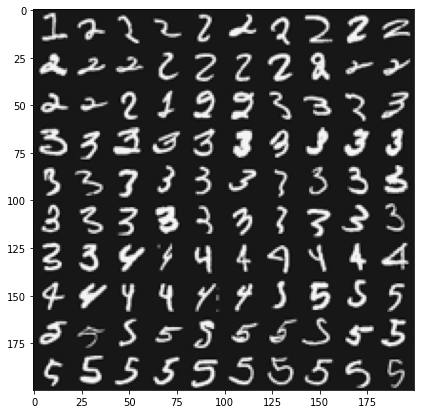

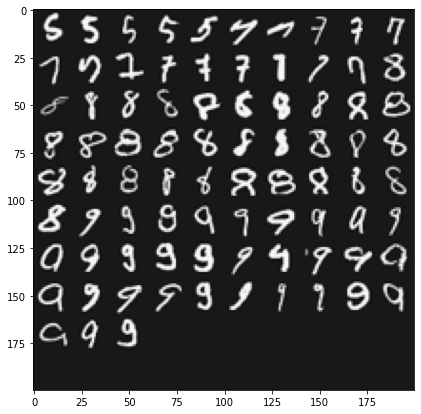

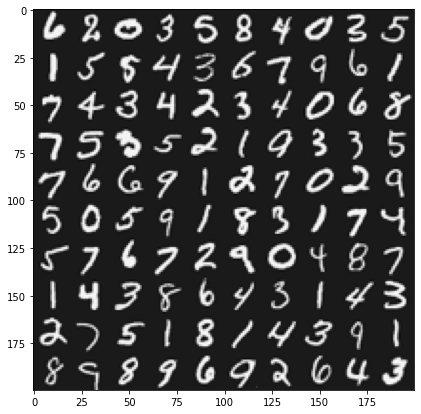

In [12]:
# displaying the wrong ones
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

### Neural Networks

In [13]:
# we have been provided with a set of network parameters (Θ(1),Θ(2)) already trained by us. These are stored in ex3weights.mat
input_file = 'database/ex3weights.mat'

mat_data = scipy.io.loadmat(input_file)
Theta1, Theta2 = mat_data['Theta1'], mat_data['Theta2']

print ("Theta1 shape: ",Theta1.shape)
print ("Theta2 shape: ",Theta2.shape)

Theta1 shape:  (25, 401)
Theta2 shape:  (10, 26)


#### Forward Propagation

In [14]:
def propagateForward(row,theta_list):
    """
    Function that given a list of Thetas, propagates the
    row of features forward, assuming the features already
    include the bias unit in the input layer, and the 
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in range(len(theta_list)):
        Theta = theta_list[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(theta_list)-1:
            return a
        a = np.insert(a,0,1) # adding the bias unit
        features = a

def predictNN(row,theta_list):
    """
    Function that takes a row of features, propagates them through the
    Neural Network, and returns the predicted integer that was handwritten
    """
    classes = [1,2,3,4,5,6,7,8,9] + [10]
    output = propagateForward(row,theta_list)
    return classes[np.argmax(np.array(output))]

In [15]:
Thetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []

for row_i in range(X.shape[0]):
    n_total += 1
    if predictNN(X[row_i],Thetas) == int(y[row_i]): 
        n_correct += 1
    else: incorrect_indices.append(row_i)
print ("Training set accuracy: %0.2f%%"%(100*(n_correct/n_total)))

Training set accuracy: 97.52%


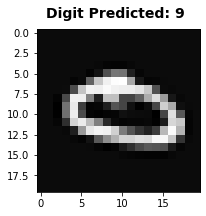

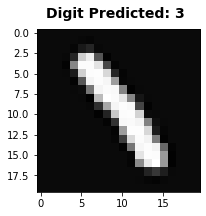

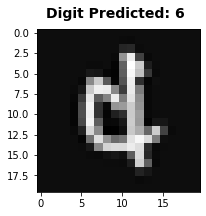

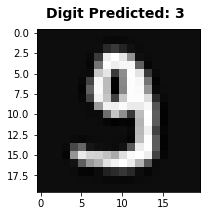

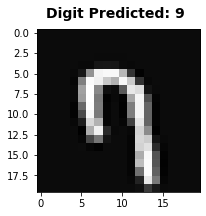

In [16]:
# checking some images our NN got wrong
for j in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = toimage(getImage(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],Thetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Digit Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')